In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
%matplotlib inline
import pylab as pl
from IPython import display

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.block1 = Block(3,64)
        self.block2 = Block(64,64)
        self.block3 = Block(64,64)
        self.block4 = Block(64,64)
        
    def forward(self, inp):
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return out.view(out.size(0),-1)

class smartPREDICTOR(nn.Module):
    def __init__(self):
        super(smartPREDICTOR, self).__init__()
        self.total = 0
        self.way = 0
        self.trainsupport = None
        self.testsupport = None
        self.weights = None
        self.sm = nn.LogSoftmax()
        
    def initialize(self, support, way):
        self.total = support.size(0)
        self.way = way
        assert self.total%way == 0,"Error: classes are not the same size!"
        self.trainsupport = support.detach().view(way,self.total//way,-1)
        self.testsupport = support.view(way,self.total//way,-1)
        self.weights = Parameter(torch.zeros(self.total).view(way,self.total//way).cuda())
        
    def printw(self):
        newweights = torch.exp(self.weights)
        newweights = newweights/torch.sum(newweights,dim=1).unsqueeze(1)
        return newweights*(self.total//self.way)
        
    def forward(self, inp, training=True):
        newinp = inp.view(inp.size(0),-1)
        sup = self.trainsupport if training else self.testsupport
        newweights = torch.exp(self.weights)
        newweights = newweights/torch.sum(newweights,dim=1).unsqueeze(1)*(self.total//self.way)
        newsup = newweights.unsqueeze(2)*sup
        centroids = torch.mean(newsup, 1).view(self.way,-1)
        distmat = torch.sum((torch.stack([centroids]*newinp.size(0))-torch.stack([newinp]*centroids.size(0))
                             .transpose(0,1))**2,2).squeeze()*-1
        probs = self.sm(distmat)
        return probs

In [3]:
trainset = torch.load('mIN_train.pth')
testset = torch.load('mIN_test.pth')
valset = torch.load('mIN_val.pth')

In [4]:
standardize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
            ])
alter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(84,padding=10),
            standardize
            ])

def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way)
    if alterful:
        li = [torch.cat([alter(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    else:
        li = [torch.cat([standardize(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    support = torch.cat([t[:trainshot,:,:,:] for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([t[trainshot:,:,:,:] for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda(),
           Variable(stargs).cuda()
          )
    
def newevaluate(embed,model,criterion,way,trainshot,testshot,theset,lr):
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,theset)
        embeds = embed(support)
        model.initialize(embeds, way)
        optimizer = optim.Adam(model.parameters(),lr=lr)
        for i in range(patience):
            model.zero_grad()
            preds = model(embeds.detach())
            loss = criterion(preds, stargs)
            loss.backward()
            optimizer.step()
    #     print(newmodel.weights.data)
        qembeds = embed(query)
        preds = model(qembeds, training=False)

        # Val loss
        loss = criterion(preds,qtargs)
        losstracker += loss.data[0]
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qtargs)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
        
    return losstracker/reps,acctracker/reps,np.var(acclist)

way = 20
evalway = 5
trainshot = 30
testshot = 5
patience = 15
reps = 50

In [5]:
torch.cuda.set_device(2)
embed = ENCODER().cuda()
model = smartPREDICTOR().cuda()
losstracker,evallosstracker,evalacctracker = [],[],[]
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113088  parameters in neural net.


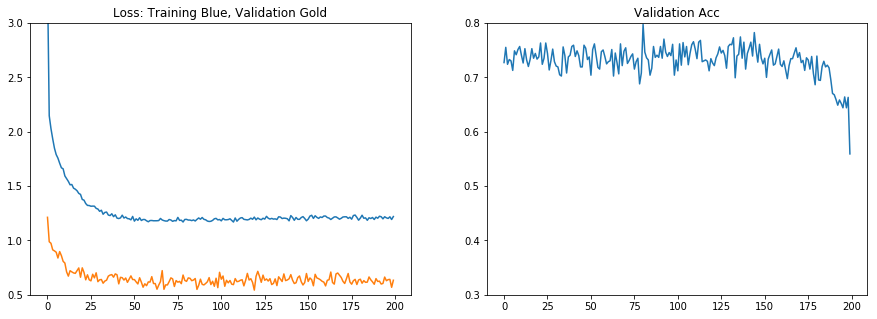

Train loss is: 1.2198468536138534
Validation accuracy is: 0.7272000000000003
Validation loss is: 0.6338160175085068
LR is: 0.0999975

Variable containing:

Columns 0 to 9 
 1.3638  0.6233  1.8626  0.8956  0.8283  0.4790  1.1368  0.4676  2.1538  1.1139
 0.6059  0.6879  2.3110  2.6493  1.3891  2.5940  0.4497  2.3701  0.5877  0.4995
 1.1206  0.8582  2.5705  0.8750  1.1384  0.3208  0.8980  0.2800  0.4006  1.6233
 1.4546  0.4253  0.4149  0.3995  0.3817  1.2683  1.3796  1.2762  0.4473  0.6739
 0.4405  0.4824  0.9908  1.2617  0.6087  2.9176  0.5185  2.1052  1.5032  0.3804

Columns 10 to 19 
 1.8393  3.0739  0.3402  1.2582  1.4352  0.3812  0.6531  1.1217  0.4047  0.4772
 0.8063  0.5105  1.3432  3.4593  0.4995  0.9166  0.5274  0.6163  0.4413  0.9617
 0.4131  0.3541  0.6561  0.5762  1.6018  0.2996  0.3831  1.1728  0.3688  1.0198
 1.0999  0.4473  0.4399  0.5294  1.5147  0.4705  0.6056  2.0794  0.4714  2.3066
 1.3916  0.7842  0.6659  2.2691  1.0935  0.5817  0.4366  0.7715  1.1710  0.5612

Columns 

In [6]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 200
epoch = 2000

runningloss = 0
te_optimizer = None
tr_optimizer = None
for it in range(20*epoch):
    if it%10==9:
        print(it+1)
    
    # Build batch
    support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    embeds = embed(support)
    model.initialize(embeds, way)
    lr = .1*it/20/epoch
    tr_optimizer = optim.Adam(model.parameters(),lr=lr)
    for i in range(patience):
        model.zero_grad()
        preds = model(embeds.detach())
        loss = criterion(preds, stargs)
        loss.backward()
        tr_optimizer.step()
#     print(model.weights.data)
    qembeds = embed(query)
    preds = model(qembeds, training=False)

    # Calculate Loss
    loss = criterion(preds, qtargs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        te_optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    te_optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        evalloss, evalacc, _ = newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset,lr)
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((0.5,3))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+
              "\nLR is: "+str(lr)+"\n")
        runningloss = 0
        print(model.printw())

# META
        

In [7]:
name = 'alpha_highshot'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type smartPREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
np.mean(evalacctracker[-50:])

0.73676800000000031

In [73]:
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax()
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         temp1 = torch.stack([centroids]*inp.size(0))
#         temp2 = torch.stack([inp]*centroids.size(0)).transpose(0,1)
#         print(temp1.size(),temp2.size())
        distmat = torch.sum((torch.stack([centroids]*inp.size(0))-torch.stack([inp]*centroids.size(0))
                             .transpose(0,1))**2,2).squeeze()*-1
        probs = self.sm(distmat)
        return probs
embed, _ = torch.load('saved_models/naive_2_noinfo.pth')
embed = embed.cuda()

In [135]:
LR = .1
MOM = 0

# Build batch
embed, model, _,_,_ = torch.load('saved_models/smart_1.pth')
support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,valset,alterful=False)
criterion = nn.NLLLoss().cuda()
embed = embed.cuda()
model = model.cuda()

# Predict
embed.zero_grad()
embeds = embed(support)
model.initialize(embeds, way)
tr_optimizer = optim.SGD(model.parameters(),lr=LR,momentum=MOM)
for i in range(100):
    model.zero_grad()
    preds = model(embeds.detach())
    loss = criterion(preds, stargs)
    loss.backward()
    tr_optimizer.step()
print(model.weights.data)
print(torch.var(model.weights.data.view(-1)),torch.max(model.weights.data),torch.min(model.weights.data))


 1.0169  1.0213  1.0213  1.0179  1.0447
 1.0113  0.9726  1.1331  0.9836  0.9862
 1.0039  1.0003  0.9998  1.0028  1.0037
 0.9991  0.9328  0.9721  0.9687  0.9521
 1.0051  1.0058  1.0060  1.0051  1.0059
 1.0152  1.0104  1.0070  1.0049  1.0134
 0.9942  1.0203  1.0038  1.0143  1.1429
 1.2525  0.8872  0.9072  0.8251  0.8151
 0.9912  1.0623  1.0139  0.9948  0.9969
 0.9555  1.0863  0.9237  0.9587  0.9434
 1.0214  1.0156  1.0299  1.0500  1.0297
 1.0020  1.0107  1.0123  1.0228  1.0025
 1.0335  1.0066  1.0020  1.0015  0.9977
 1.0047  1.0092  1.0054  1.0066  1.0185
 1.0192  1.0703  1.0407  1.0279  1.0212
 0.9825  0.9729  0.9663  1.0503  0.9678
 1.0511  0.9693  0.9869  0.9660  0.9991
 1.0562  1.0248  1.0581  1.0068  1.0160
 1.0243  1.0424  1.0349  1.0258  1.0305
 1.0190  1.0120  1.0185  1.0085  1.0203
[torch.cuda.FloatTensor of size 20x5 (GPU 0)]

0.002654873766005039 1.2525303363800049 0.8151440024375916


In [30]:
torch.mean(torch.norm(embeds,2,1))

Variable containing:
 20.6023
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [ ]:
# BASELINE

In [25]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET

(0.91514739215374, 0.6385333333333335, 0.010876071111111113)


In [13]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,trainset))
# TRAINSET

(0.6446040686964989, 0.7650666666666668, 0.0088703288888888881)


In [13]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, NAIVE

(0.7136507552862167, 0.7288000000000002, 0.012978559999999997)


In [15]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, SMART

(0.726845205873251, 0.7353333333333336, 0.0094271111111111101)


In [ ]:
# EXPERIMENTS

In [71]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, SMART. LR .1, MOM 0

(0.9770350706577301, 0.6170666666666665, 0.010962062222222221)


In [77]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, NAIVE. LR .1, MOM 0

(0.9578658026456833, 0.6214000000000002, 0.013506039999999999)


In [68]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 50 PATIENCE, SMART. LR .1, MOM 0.5

(0.9450288346409798, 0.6406666666666669, 0.013203111111111108)


In [64]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 20 PATIENCE, SMART. LR 1, MOM .5

(0.9806817117333412, 0.6148000000000002, 0.011196071111111108)


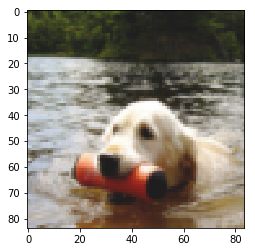

In [132]:
from random import randint
pl.figure()
pl.imshow(testset[randint(0,len(testset)-1)][randint(0,len(testset[0])-1)])
pl.show()

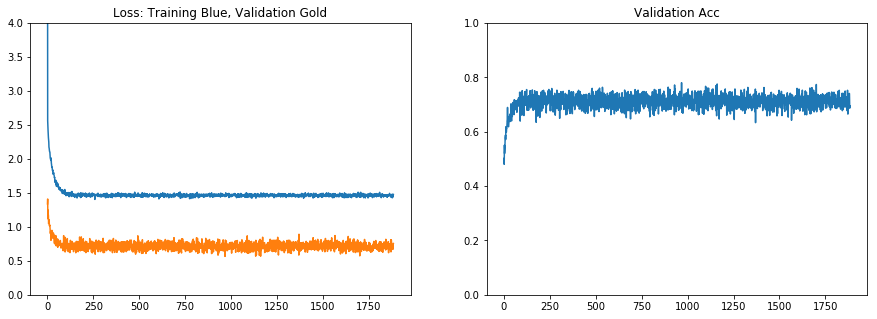

Train loss is: 1.4755005943775177
Validation accuracy is: 0.6951111111111113
Validation loss is: 0.7553736646970113

188500
188510
188520
188530
188540
188550


KeyboardInterrupt: 

In [6]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 100
epoch = 2000

losstracker,evallosstracker,evalacctracker = [],[],[]
runningloss = 0
optimizer = None
for it in range(epoch*100):
    if it%10==0:
        print(it)
    
    # Build batch
    support, query, qtargs, _ = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds = embed(support)
    qembeds = embed(query)
    preds = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        evalloss, evalacc = evaluate(embed,model,criterion,evalway,trainshot,testshot)
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((0,4))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker)
        pl.ylim((0,1))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0


In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]